# Bigram语言模型实践
本notebook是对第01章Bigram语言模型教程的补充材料，提供交互式的实例和可视化，帮助理解Bigram模型的工作原理。

## 1. 导入必要的库

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# 导入我们的Bigram模型实现
from bigram_model import (
    preprocess_text,
    preprocess_chinese_text,
    train_bigram_model,
    generate_text,
    calculate_perplexity,
    visualize_bigram_probabilities
)

# 设置随机种子，确保结果可重现
random.seed(42)


## 2. Bigram模型基础
Bigram（二元语法）模型是最简单的N-gram模型之一，它基于一阶马尔可夫假设，认为一个词的出现只与其前一个词相关。
在Bigram模型中，一个句子的概率可以表示为：

## 3. 英文文本的Bigram模型示例

In [12]:
# 英文示例文本
english_text = """
The quick brown fox jumps over the lazy dog. 
The dog barks at the fox. 
The fox runs away quickly.
A language model is a probability distribution over sequences of words.
Bigram models consider only the previous word when predicting the next word.
"""

# 预处理文本
sentences, vocab = preprocess_text(english_text)
print(f"词汇表大小: {len(vocab)}")
print(f"句子数量: {len(sentences)}")

# 展示预处理后的前两个句子
print("\n预处理后的前两个句子:")
for i in range(min(2, len(sentences))):
    print(f"句子 {i+1}: {sentences[i]}")

# 展示部分词汇表
print("\n部分词汇表:")
print(list(vocab)[:10])

词汇表大小: 33
句子数量: 5

预处理后的前两个句子:
句子 1: ['<s>', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '</s>']
句子 2: ['<s>', 'the', 'dog', 'barks', 'at', 'the', 'fox', '</s>']

部分词汇表:
['away', 'model', 'quick', 'fox', 'is', 'brown', 'next', 'runs', 'distribution', '<s>']


### 3.1 训练不同平滑方法的Bigram模型

In [13]:
# 训练Bigram模型（使用不同的平滑方法）
smoothing_methods = ['none', 'laplace', 'add_k', 'interpolation']
models = {}

for method in smoothing_methods:
    if method == 'add_k':
        models[method] = train_bigram_model(sentences, vocab, smoothing=method, k=0.5)[0]
    else:
        models[method] = train_bigram_model(sentences, vocab, smoothing=method)[0]
    
    print(f"使用{method}平滑方法训练完成")

使用none平滑方法训练完成
使用laplace平滑方法训练完成
使用add_k平滑方法训练完成
使用interpolation平滑方法训练完成


### 3.2 探索条件概率

In [14]:
# 探索某个词后面可能出现的词及其概率
word = 'the'  # 尝试改变这个词，查看不同词的条件概率

print(f"词'{word}'后面可能出现的词及其概率（使用拉普拉斯平滑）:")
if word in models['laplace']:
    # 获取条件概率，按概率从高到低排序
    next_words = [(next_word, prob) for next_word, prob in models['laplace'][word].items() if prob > 0]
    next_words.sort(key=lambda x: x[1], reverse=True)
    
    # 显示前10个最可能的词
    for next_word, prob in next_words[:10]:
        print(f"  {next_word}: {prob:.4f}")
else:
    print(f"词'{word}'不在模型中")

词'the'后面可能出现的词及其概率（使用拉普拉斯平滑）:
  fox: 0.0750
  quick: 0.0500
  next: 0.0500
  lazy: 0.0500
  previous: 0.0500
  dog: 0.0500
  away: 0.0250
  model: 0.0250
  is: 0.0250
  brown: 0.0250


### 3.3 不同平滑方法的比较

In [15]:
# 比较不同平滑方法对同一个词的条件概率的影响
word = 'the'  # 尝试改变这个词
next_word = 'fox'  # 尝试改变这个词

print(f"词'{word}'后面出现词'{next_word}'的概率（不同平滑方法）:")
for method, model in models.items():
    if word in model and next_word in model[word]:
        prob = model[word][next_word]
        print(f"  {method}平滑: {prob:.6f}")
    else:
        print(f"  {method}平滑: 0.000000")

词'the'后面出现词'fox'的概率（不同平滑方法）:
  none平滑: 0.285714
  laplace平滑: 0.075000
  add_k平滑: 0.106383
  interpolation平滑: 0.263393


### 3.4 使用模型生成文本

In [19]:
# 生成文本
print("使用不同平滑方法生成的文本：")
for method, model in models.items():
    print(f"\n{method}平滑方法：")
    for _ in range(3):
        generated_text = generate_text(model)
        print(f"  生成的文本: {generated_text}")

使用不同平滑方法生成的文本：

none平滑方法：
  生成的文本: a probability distribution over sequences of words
  生成的文本: the dog barks at the fox runs away quickly
  生成的文本: the previous word

laplace平滑方法：
  生成的文本: consider probability probability a bigram predicting fox sequences lazy dog distribution next over sequences <s> <s> only over language at
  生成的文本: model predicting words when when language is consider runs quickly model lazy predicting <s> the sequences probability when predicting
  生成的文本: jumps brown <s> when of

add_k平滑方法：
  生成的文本: the quick
  生成的文本: word dog brown when quick brown
  生成的文本: jumps distribution is dog <s> a previous probability

interpolation平滑方法：
  生成的文本: the dog barks at the fox jumps over sequences of the next predicting when the fox runs <s> the dog
  生成的文本: a probability distribution over the dog
  生成的文本: fox jumps over the dog barks at the lazy dog


### 3.5 计算困惑度

In [20]:
# 计算困惑度
print("不同平滑方法的困惑度：")
for method, model in models.items():
    perplexity = calculate_perplexity(model, sentences)
    print(f"{method}平滑方法的困惑度: {perplexity:.4f}")

不同平滑方法的困惑度：
none平滑方法的困惑度: 1.7127
laplace平滑方法的困惑度: 16.7214
add_k平滑方法的困惑度: 11.7394
interpolation平滑方法的困惑度: 1.8856


### 3.6 可视化Bigram概率

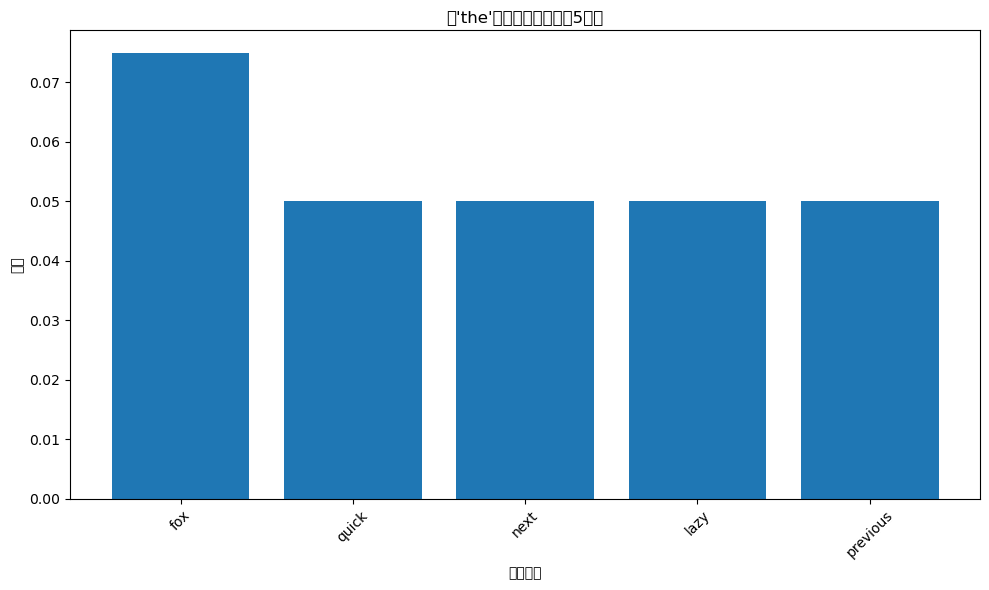

In [21]:
# 可视化某些词后面最可能出现的词
word = 'the'  # 尝试改变这个词
visualize_bigram_probabilities(models['laplace'], word, top_n=5)

## 4. 中文文本的Bigram模型示例

词汇表大小: 40
句子数量: 3

预处理后的第一个句子:
['<s>', '自', '然', '语', '言', '处', '理', '是', '人', '工', '智', '能', '的', '重', '要', '分', '支', '</s>']

生成的中文文本：
  a 模 <s> 本 然 畅 工 能 之 文 重 的 生 然 B 简 单 单 言 r 处 流
  能 然 工 畅 可 a 自 g 人 是 B 智 生 工 型 是 可 畅 然 然 B 单 要 B 然 i 成 成 语
  理 模 a 智 能 之 要 大 <s> 大 支 型 智 最 单 r 简 一 分 最 流 大 分 型 文 <s> 模 畅 本 语
  的 r 重 生 理 B 本 之 型 本 B 言 之 能 r <s> 一 单 r 分 最 模 i 简 型 自 语 文 可 B
  单 人 <s> 简 重 理 的 型 模 的 分 重 g 分 言 m 流 言 本 以 a 流 之 智 能 的 文 i 单 工

困惑度: 18.9587

可视化'语'后面最可能出现的字：


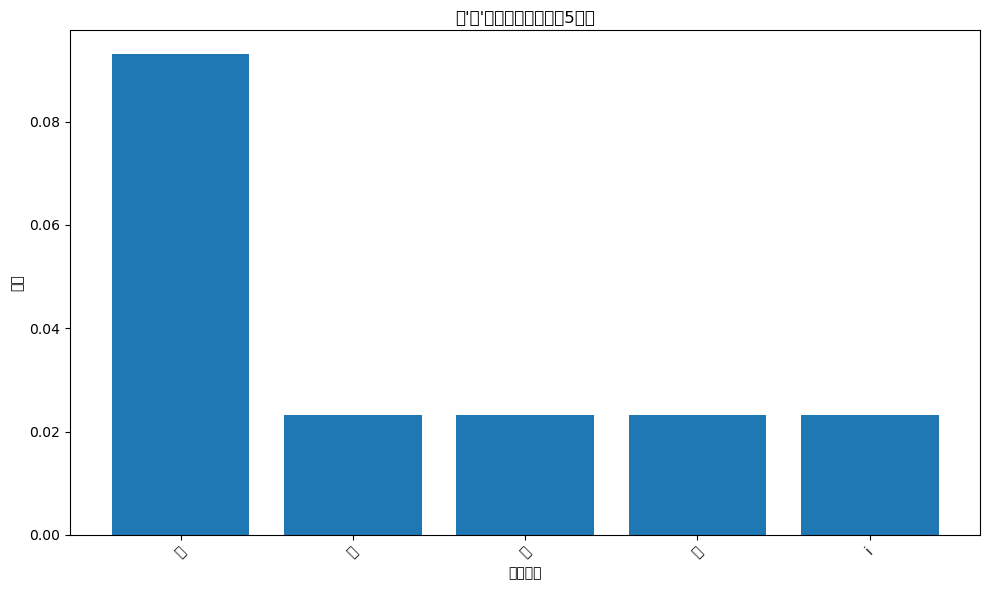

In [23]:
# 中文示例文本
chinese_text = """
自然语言处理是人工智能的重要分支。
大语言模型可以生成流畅的文本。
Bigram模型是最简单的语言模型之一。
"""

# 预处理中文文本
chinese_sentences, chinese_vocab = preprocess_chinese_text(chinese_text)
print(f"词汇表大小: {len(chinese_vocab)}")
print(f"句子数量: {len(chinese_sentences)}")

# 展示预处理后的第一个句子
print("\n预处理后的第一个句子:")
print(chinese_sentences[0])

# 训练中文Bigram模型
chinese_model, _, _ = train_bigram_model(chinese_sentences, chinese_vocab, smoothing='laplace')

# 生成中文文本
print("\n生成的中文文本：")
for _ in range(5):
    generated_text = generate_text(chinese_model, max_length=30)
    print(f"  {generated_text}")

# 计算困惑度
perplexity = calculate_perplexity(chinese_model, chinese_sentences)
print(f"\n困惑度: {perplexity:.4f}")

# 可视化某些字后面最可能出现的字
print("\n可视化'语'后面最可能出现的字：")
visualize_bigram_probabilities(chinese_model, '语', top_n=5)

## 5. Bigram模型的局限性分析

In [24]:
# 创建一个包含长距离依赖的文本
long_dependency_text = """
The man who lives next door works at the hospital. He is a doctor.
The woman who lives upstairs works at the school. She is a teacher.
"""

sentences, vocab = preprocess_text(long_dependency_text)
bigram_model, _, _ = train_bigram_model(sentences, vocab, smoothing='laplace')

print("原始文本：")
print(long_dependency_text)

print("\nBigram模型生成的文本：")
for _ in range(5):
    generated_text = generate_text(bigram_model, max_length=30)
    print(f"  {generated_text}")

print("\nBigram模型的局限性：")
print("1. 只考虑前一个词的影响，无法捕捉长距离依赖关系")
print("2. 生成的文本可能在局部上看起来合理，但整体上缺乏连贯性和一致性")
print("3. 对于稀疏数据，即使使用平滑技术，模型的性能也会受到限制")
print("4. 无法理解语义，只能基于统计规律生成文本")

原始文本：

The man who lives next door works at the hospital. He is a doctor.
The woman who lives upstairs works at the school. She is a teacher.


Bigram模型生成的文本：
  he is she a school lives <s> at school door the man she at the at teacher he she next door doctor hospital teacher he next door the man the
  woman lives doctor school upstairs the who next door school the at <s> upstairs works is a teacher he
  he teacher a man who
  school at hospital doctor lives he woman
  <s> <s> man who man hospital a next next hospital he she hospital woman man who woman who upstairs doctor woman she hospital

Bigram模型的局限性：
1. 只考虑前一个词的影响，无法捕捉长距离依赖关系
2. 生成的文本可能在局部上看起来合理，但整体上缺乏连贯性和一致性
3. 对于稀疏数据，即使使用平滑技术，模型的性能也会受到限制
4. 无法理解语义，只能基于统计规律生成文本
